# <center>__Import necessary libraries__</center>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade scikeras

In [3]:
pip install imbalanced-learn

In [5]:
# For data preprocessing
import nltk
import pandas as pd
import numpy as np
import re

# For exploratory data analysis
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# For feature engineering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# For model training
from sklearn.model_selection import train_test_split
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# For model optimization
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier
from sklearn.utils import shuffle

# For model testing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score

# For saving the important objects
import pickle

In [6]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
# Load the dataset
true_df = pd.read_csv("/content/drive/MyDrive/True.csv")
fake_df = pd.read_csv("/content/drive/MyDrive/Fake.csv")

In [8]:
# Examine dataset
true_df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

# <center>__Data Preprocessing__</center>

In [9]:
# Labeling the fake and true news
fake_df['label'] = 1
true_df['label'] = 0

We will shuffle the two datasets to prevent any biases.

In [10]:
# Combining the dataset
df=pd.concat([fake_df, true_df])

# Random permutation of integers
random_permutation = np.random.permutation(len(df))

# Shuffles the rows of the dataset
df=df.iloc[random_permutation]

# Displaying the columns
print(df.columns)

Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')


In [11]:
# Examine and handle missing values (if any)
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [12]:
# Check for duplicate rows and remove if necessary
df.duplicated().sum()

209

In [13]:
# Remove duplicate rows
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

# <center>__Data Exploration__</center>

In [14]:
# Display basic statistics and information about the dataset
print("Dataset Information:")
print(df.info())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44689 entries, 0 to 44688
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44689 non-null  object
 1   text     44689 non-null  object
 2   subject  44689 non-null  object
 3   date     44689 non-null  object
 4   label    44689 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
None


In [15]:
# Display summary statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
              label
count  44689.000000
mean       0.525364
std        0.499362
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000


In [16]:
# Check the distribution of classes
print("\nClass Distribution:")
print(df['label'].value_counts())


Class Distribution:
1    23478
0    21211
Name: label, dtype: int64


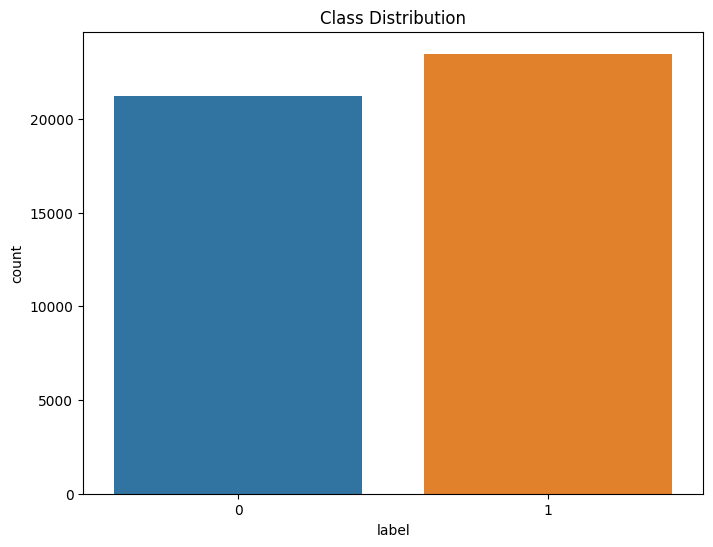

In [17]:
# Visualize the distribution of classes
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.show()

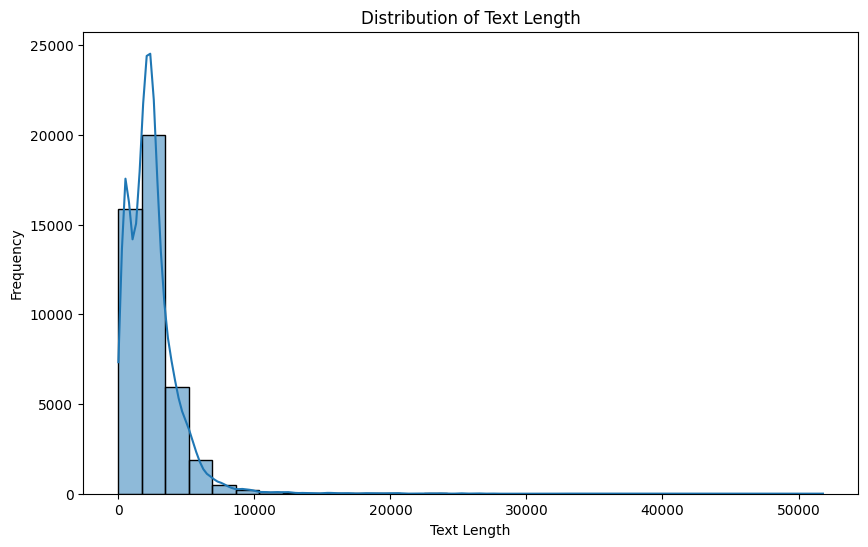

In [18]:
# Explore the distribution of the length of news articles
df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

## Insights from graph


- The majority of the text lengths fall between 0 and 10000, with a few outliers between 20000 and 50000. This means that most of the texts are short or medium in length, while some are very long.
- The histogram has a right-skewed shape, which means that there are more texts with lower lengths than higher lengths. The mean (average) text length is likely to be greater than the median (middle) text length, and both are likely to be greater than the mode (most common) text length.
- The histogram has a high variability, which means that there is a large range of text lengths in the data set. The standard deviation, which measures how much the text lengths vary from the mean, is likely to be high. The coefficient of variation, which measures the ratio of the standard deviation to the mean, is also likely to be high.


Next, we will visualize the most common words in fake and true news articles using word clouds

In [19]:
# Generate word clouds for fake and true news articles
fake_text = ' '.join(df[df['label'] == 1]['text'])
true_text = ' '.join(df[df['label'] == 0]['text'])

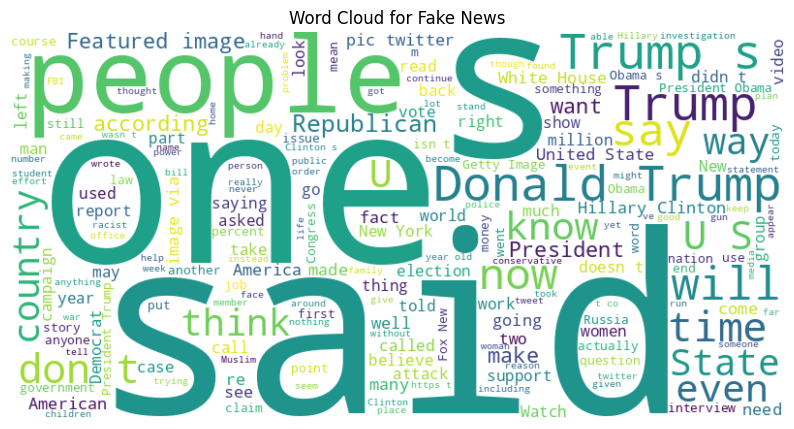

In [20]:
# Generate WordCloud for Fake News
plt.figure(figsize=(10, 6))
wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('Word Cloud for Fake News')
plt.axis('off')
plt.show()

## Insights from Word Cloud

- The most prominent words are "Donald Trump", "said", "people", "country", and "fake news". This suggests that the image is related to the topic of fake news and politics, and that these words are the most common or important in the text.
- The image also contains words related to specific locations, such as "New York", "State", and "America", as well as words related to political parties, such as "Hillary", "President", and "Republican". This indicates that the text may be about the US political scene, and that it may mention specific events, people, or places that are relevant to the topic.

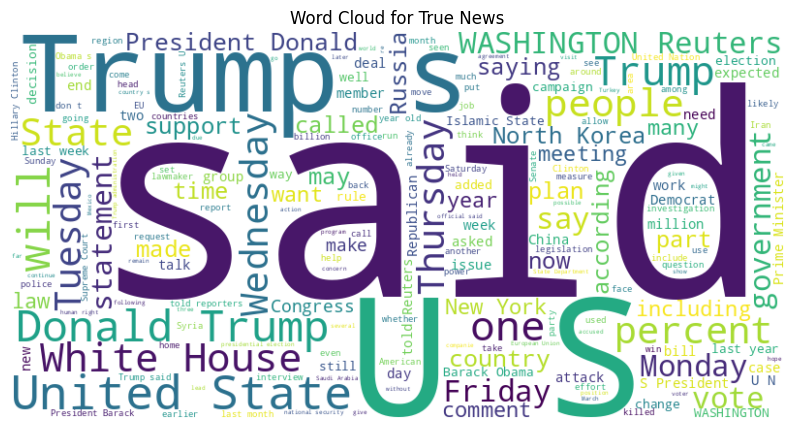

In [21]:
# Generate WordCloud for True News
plt.figure(figsize=(10, 6))
wordcloud_true = WordCloud(width=800, height=400, background_color='white').generate(true_text)
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.title('Word Cloud for True News')
plt.axis('off')
plt.show()

## Insights from Word Cloud
- The news articles are about politics and the United States. The most prominent words are "United States", "Trump", "White House", "Democrat", "Republican", "vote", "election", "Russia", "China", "North Korea", "Barack Obama", "Hillary Clinton", and "Donald Trump". This indicates that the news articles cover topics such as the US presidential election, the US foreign policy, the US domestic issues, and the US political parties and leaders.
- The image also contains words related to specific days of the week, such as "Thursday", "Friday", "Monday", "Wednesday", "Tuesday", "Saturday", and "Sunday". This suggests that the news articles are updated regularly and that they may report on events that happened on those days.

# <center>__Feature Engineering__</center>

In [22]:
# Filtering the dataset
filterd_df=df.loc[:, ['title', 'text', "subject", 'label']]
filterd_df.head()

title  \
0  Greens say no support for Macron's EZ budget i...   
1  U.S. senator threatens to curb aid over U.N. r...   
2  House ethics panel launches wide-ranging probe...   
3  Two-thirds of Japan voters oppose PM Abe calli...   
4   Donald Trump: ‘We Should Just Cancel The Elec...   

                                                text       subject  label  
0  BERLIN (Reuters) - None of the German parties ...     worldnews      0  
1  WASHINGTON (Reuters) - A top U.S. senator who ...  politicsNews      0  
2  WASHINGTON (Reuters) - The U.S. House of Repre...  politicsNews      0  
3  TOKYO (Reuters) - Almost two-thirds of Japanes...     worldnews      0  
4  At a rally in Toledo, Ohio, Trump made his mos...          News      1

In [23]:
# Examining the filtered dataset
filterd_df['training_feature'] = filterd_df['title']+' '+filterd_df['text']+' '+filterd_df['subject']
filterd_df.head()

title  \
0  Greens say no support for Macron's EZ budget i...   
1  U.S. senator threatens to curb aid over U.N. r...   
2  House ethics panel launches wide-ranging probe...   
3  Two-thirds of Japan voters oppose PM Abe calli...   
4   Donald Trump: ‘We Should Just Cancel The Elec...   

                                                text       subject  label  \
0  BERLIN (Reuters) - None of the German parties ...     worldnews      0   
1  WASHINGTON (Reuters) - A top U.S. senator who ...  politicsNews      0   
2  WASHINGTON (Reuters) - The U.S. House of Repre...  politicsNews      0   
3  TOKYO (Reuters) - Almost two-thirds of Japanes...     worldnews      0   
4  At a rally in Toledo, Ohio, Trump made his mos...          News      1   

                                    training_feature  
0  Greens say no support for Macron's EZ budget i...  
1  U.S. senator threatens to curb aid over U.N. r...  
2  House ethics panel launches wide-ranging probe...  
3  Two-thirds of Japan voters oppose PM Abe calli...  
4   Donald Trump: ‘We Should Just Cancel The Elec...

In [24]:
#  Perform text cleaning (e.g., removing special characters, lowercasing)
filterd_df['training_feature'] = filterd_df['training_feature'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x).lower())

In [25]:

# Assuming filterd_df['training_feature'] contains your text data
texts = filterd_df['training_feature']

# Create a tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# Tokenize the text into words
filterd_df['tokenized_text'] = filterd_df['training_feature'].apply(lambda x: x.split())

# Save the tokenizer to a file
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [26]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
filterd_df['filtered_text'] = filterd_df['tokenized_text'].apply(lambda x: [word for word in x if word not in stop_words])

In [27]:
# Lemmatize words to reduce them to their base or root form
lemmatizer = WordNetLemmatizer()
filterd_df['lemmatized_text'] = filterd_df['filtered_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# <center>__Model Training, Testing, and Optimization__</center>

In [63]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    filterd_df[['lemmatized_text']],
    filterd_df['label'],
    test_size=0.2,
    random_state=42
)


In [65]:
# Initializing the RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Apply oversampling to the training data
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Convert X_train_resampled to a list of strings
X_train_resampled = X_train_resampled['lemmatized_text'].apply(lambda x: x[0]).astype(str).tolist()


In [66]:
# Tokenize and pad the sequences
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_resampled)
X_train_sequences = tokenizer.texts_to_sequences(X_train_resampled)
X_test_sequences = tokenizer.texts_to_sequences(X_test['lemmatized_text'].apply(lambda x: x[0]).astype(str).tolist())
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')

# Convert y_train_resampled to a 1D array
y_train_resampled = y_train_resampled.ravel()


In [67]:
# Combine X_train_padded and y_train_resampled for shuffling
combined_data = list(zip(X_train_padded, y_train_resampled))
shuffle(combined_data, random_state=42)

# Unzip the shuffled data back to X_train_padded and y_train_resampled
X_train_padded, y_train_resampled = zip(*combined_data)

# Split the shuffled data into training and testing sets
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_train_padded, y_train_resampled, test_size=0.2, random_state=42)


In [68]:
# Build the neural network model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=300, input_length=max_len))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
# Check the shape
print(np.array(X_train_final).shape)
print(np.array(y_train_final).shape)

(29929, 200)
(29929,)


In [71]:
# Combine X_train_padded and y_train_resampled for shuffling
combined_data = list(zip(X_train_padded, y_train_resampled))
shuffle(combined_data, random_state=42)

# Unzip the shuffled data back to X_train_padded and y_train_resampled
X_train_padded, y_train_resampled = zip(*combined_data)

# Convert X_train_padded to a NumPy array
X_train_padded = np.array(X_train_padded)

# Convert y_train_resampled to a NumPy array
y_train_resampled = np.array(y_train_resampled)


In [72]:
# Define callbacks for early stopping and model checkpoint
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_padded, y_train_resampled,
    epochs=2,
    batch_size=2,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stopping]
)

Epoch 1/2
18706/18706 [==============================] - 585s 31ms/step - loss: 0.4163 - accuracy: 0.7945 - val_loss: 0.3712 - val_accuracy: 0.8081
Epoch 2/2
18706/18706 [==============================] - 615s 33ms/step - loss: 0.3326 - accuracy: 0.8551 - val_loss: 0.3806 - val_accuracy: 0.8196


In [73]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

280/280 [==============================] - 5s 13ms/step - loss: 0.3806 - accuracy: 0.8196
Test Loss: 0.3806, Test Accuracy: 0.8196


In [74]:
y_pred = model.predict(X_test_padded)

280/280 [==============================] - 6s 16ms/step


In [75]:
# Assuming y_pred is in probability format
threshold = 0.5  # Adjust the threshold based on your model and preferences
y_pred_binary = (y_pred > threshold).astype(int)

In [76]:
# Assuming y_test is in continuous format
y_test_binary = (y_test > threshold).astype(int)

In [77]:
print("Confusion Matrix:\n", confusion_matrix(y_test_binary, y_pred_binary))

Confusion Matrix:
 [[3442  724]
 [ 888 3884]]


In [78]:
print("\nClassification Report:\n", classification_report(y_test_binary, y_pred_binary))


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81      4166
           1       0.84      0.81      0.83      4772

    accuracy                           0.82      8938
   macro avg       0.82      0.82      0.82      8938
weighted avg       0.82      0.82      0.82      8938



In [79]:
# Save the entire model
model.save('fake_news_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Define a parameter grid
param_grid = {
    'embedding_dim': [64, 128],
    'lstm_units': [32, 64],
    'dense_units': [32, 64],
    'dropout_rate': [0.3, 0.5],
}

# Create a model
def create_model(embedding_dim, lstm_units, dense_units, dropout_rate):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
    model.add(Bidirectional(LSTM(lstm_units)))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model creation function with KerasClassifier
keras_model = KerasClassifier(build_fn=create_model, epochs=3, batch_size=32, verbose=2, dense_units=32, embedding_dim=64, lstm_units=32, dropout_rate=0.2)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=keras_model,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
)

# Fit the grid search to the data
grid_result = grid_search.fit(X_train_padded, y_train_resampled)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 31s - loss: 0.4586 - accuracy: 0.7564 - 31s/epoch - 40ms/step
Epoch 2/3
780/780 - 21s - loss: 0.3367 - accuracy: 0.8470 - 21s/epoch - 27ms/step
Epoch 3/3
780/780 - 20s - loss: 0.3196 - accuracy: 0.8477 - 20s/epoch - 26ms/step
390/390 - 7s - 7s/epoch - 18ms/step
[CV] END dense_units=32, dropout_rate=0.3, embedding_dim=64, lstm_units=32; total time= 1.7min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 31s - loss: 0.4641 - accuracy: 0.7600 - 31s/epoch - 39ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3393 - accuracy: 0.8493 - 20s/epoch - 26ms/step
Epoch 3/3
780/780 - 21s - loss: 0.3169 - accuracy: 0.8518 - 21s/epoch - 27ms/step
390/390 - 6s - 6s/epoch - 16ms/step
[CV] END dense_units=32, dropout_rate=0.3, embedding_dim=64, lstm_units=32; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 30s - loss: 0.4520 - accuracy: 0.7651 - 30s/epoch - 38ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3329 - accuracy: 0.8500 - 20s/epoch - 25ms/step
Epoch 3/3
780/780 - 19s - loss: 0.3122 - accuracy: 0.8557 - 19s/epoch - 25ms/step
390/390 - 7s - 7s/epoch - 17ms/step
[CV] END dense_units=32, dropout_rate=0.3, embedding_dim=64, lstm_units=32; total time= 1.4min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 32s - loss: 0.4536 - accuracy: 0.7616 - 32s/epoch - 41ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3374 - accuracy: 0.8442 - 20s/epoch - 26ms/step
Epoch 3/3
780/780 - 21s - loss: 0.3162 - accuracy: 0.8491 - 21s/epoch - 27ms/step
390/390 - 5s - 5s/epoch - 14ms/step
[CV] END dense_units=32, dropout_rate=0.3, embedding_dim=64, lstm_units=64; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 29s - loss: 0.4670 - accuracy: 0.7549 - 29s/epoch - 37ms/step
Epoch 2/3
780/780 - 22s - loss: 0.3391 - accuracy: 0.8476 - 22s/epoch - 28ms/step
Epoch 3/3
780/780 - 20s - loss: 0.3155 - accuracy: 0.8523 - 20s/epoch - 26ms/step
390/390 - 7s - 7s/epoch - 17ms/step
[CV] END dense_units=32, dropout_rate=0.3, embedding_dim=64, lstm_units=64; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 29s - loss: 0.4576 - accuracy: 0.7604 - 29s/epoch - 37ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3341 - accuracy: 0.8525 - 20s/epoch - 26ms/step
Epoch 3/3
780/780 - 20s - loss: 0.3090 - accuracy: 0.8541 - 20s/epoch - 25ms/step
390/390 - 6s - 6s/epoch - 16ms/step
[CV] END dense_units=32, dropout_rate=0.3, embedding_dim=64, lstm_units=64; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 31s - loss: 0.4522 - accuracy: 0.7636 - 31s/epoch - 40ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3412 - accuracy: 0.8441 - 20s/epoch - 26ms/step
Epoch 3/3
780/780 - 19s - loss: 0.3133 - accuracy: 0.8491 - 19s/epoch - 25ms/step
390/390 - 6s - 6s/epoch - 15ms/step
[CV] END dense_units=32, dropout_rate=0.3, embedding_dim=128, lstm_units=32; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 28s - loss: 0.4548 - accuracy: 0.7605 - 28s/epoch - 36ms/step
Epoch 2/3
780/780 - 21s - loss: 0.3341 - accuracy: 0.8503 - 21s/epoch - 27ms/step
Epoch 3/3
780/780 - 19s - loss: 0.3101 - accuracy: 0.8538 - 19s/epoch - 25ms/step
390/390 - 5s - 5s/epoch - 13ms/step
[CV] END dense_units=32, dropout_rate=0.3, embedding_dim=128, lstm_units=32; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 29s - loss: 0.4499 - accuracy: 0.7687 - 29s/epoch - 37ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3306 - accuracy: 0.8517 - 20s/epoch - 25ms/step
Epoch 3/3
780/780 - 21s - loss: 0.3084 - accuracy: 0.8558 - 21s/epoch - 27ms/step
390/390 - 5s - 5s/epoch - 13ms/step
[CV] END dense_units=32, dropout_rate=0.3, embedding_dim=128, lstm_units=32; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 30s - loss: 0.4635 - accuracy: 0.7577 - 30s/epoch - 38ms/step
Epoch 2/3
780/780 - 21s - loss: 0.3383 - accuracy: 0.8440 - 21s/epoch - 27ms/step
Epoch 3/3
780/780 - 21s - loss: 0.3118 - accuracy: 0.8482 - 21s/epoch - 27ms/step
390/390 - 5s - 5s/epoch - 13ms/step
[CV] END dense_units=32, dropout_rate=0.3, embedding_dim=128, lstm_units=64; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 30s - loss: 0.4506 - accuracy: 0.7663 - 30s/epoch - 38ms/step
Epoch 2/3
780/780 - 21s - loss: 0.3341 - accuracy: 0.8512 - 21s/epoch - 27ms/step
Epoch 3/3
780/780 - 21s - loss: 0.3120 - accuracy: 0.8540 - 21s/epoch - 27ms/step
390/390 - 6s - 6s/epoch - 15ms/step
[CV] END dense_units=32, dropout_rate=0.3, embedding_dim=128, lstm_units=64; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 32s - loss: 0.4443 - accuracy: 0.7718 - 32s/epoch - 41ms/step
Epoch 2/3
780/780 - 21s - loss: 0.3297 - accuracy: 0.8524 - 21s/epoch - 27ms/step
Epoch 3/3
780/780 - 20s - loss: 0.3071 - accuracy: 0.8536 - 20s/epoch - 26ms/step
390/390 - 6s - 6s/epoch - 16ms/step
[CV] END dense_units=32, dropout_rate=0.3, embedding_dim=128, lstm_units=64; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 29s - loss: 0.4812 - accuracy: 0.7466 - 29s/epoch - 37ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3478 - accuracy: 0.8460 - 20s/epoch - 25ms/step
Epoch 3/3
780/780 - 19s - loss: 0.3197 - accuracy: 0.8488 - 19s/epoch - 25ms/step
390/390 - 7s - 7s/epoch - 18ms/step
[CV] END dense_units=32, dropout_rate=0.5, embedding_dim=64, lstm_units=32; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 29s - loss: 0.4831 - accuracy: 0.7428 - 29s/epoch - 37ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3443 - accuracy: 0.8493 - 20s/epoch - 25ms/step
Epoch 3/3
780/780 - 19s - loss: 0.3193 - accuracy: 0.8532 - 19s/epoch - 25ms/step
390/390 - 6s - 6s/epoch - 15ms/step
[CV] END dense_units=32, dropout_rate=0.5, embedding_dim=64, lstm_units=32; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 32s - loss: 0.4639 - accuracy: 0.7624 - 32s/epoch - 40ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3397 - accuracy: 0.8505 - 20s/epoch - 26ms/step
Epoch 3/3
780/780 - 19s - loss: 0.3157 - accuracy: 0.8565 - 19s/epoch - 25ms/step
390/390 - 6s - 6s/epoch - 15ms/step
[CV] END dense_units=32, dropout_rate=0.5, embedding_dim=64, lstm_units=32; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 30s - loss: 0.4613 - accuracy: 0.7566 - 30s/epoch - 39ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3401 - accuracy: 0.8471 - 20s/epoch - 26ms/step
Epoch 3/3
780/780 - 21s - loss: 0.3187 - accuracy: 0.8500 - 21s/epoch - 26ms/step
390/390 - 5s - 5s/epoch - 13ms/step
[CV] END dense_units=32, dropout_rate=0.5, embedding_dim=64, lstm_units=64; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 30s - loss: 0.4757 - accuracy: 0.7476 - 30s/epoch - 38ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3436 - accuracy: 0.8468 - 20s/epoch - 25ms/step
Epoch 3/3
780/780 - 21s - loss: 0.3173 - accuracy: 0.8506 - 21s/epoch - 27ms/step
390/390 - 5s - 5s/epoch - 14ms/step
[CV] END dense_units=32, dropout_rate=0.5, embedding_dim=64, lstm_units=64; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 32s - loss: 0.4655 - accuracy: 0.7606 - 32s/epoch - 41ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3408 - accuracy: 0.8499 - 20s/epoch - 26ms/step
Epoch 3/3
780/780 - 21s - loss: 0.3151 - accuracy: 0.8540 - 21s/epoch - 28ms/step
390/390 - 5s - 5s/epoch - 13ms/step
[CV] END dense_units=32, dropout_rate=0.5, embedding_dim=64, lstm_units=64; total time= 1.4min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 29s - loss: 0.4604 - accuracy: 0.7638 - 29s/epoch - 38ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3397 - accuracy: 0.8480 - 20s/epoch - 25ms/step
Epoch 3/3
780/780 - 21s - loss: 0.3173 - accuracy: 0.8479 - 21s/epoch - 26ms/step
390/390 - 5s - 5s/epoch - 13ms/step
[CV] END dense_units=32, dropout_rate=0.5, embedding_dim=128, lstm_units=32; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 28s - loss: 0.4669 - accuracy: 0.7570 - 28s/epoch - 36ms/step
Epoch 2/3
780/780 - 21s - loss: 0.3406 - accuracy: 0.8508 - 21s/epoch - 27ms/step
Epoch 3/3
780/780 - 20s - loss: 0.3141 - accuracy: 0.8543 - 20s/epoch - 25ms/step
390/390 - 7s - 7s/epoch - 17ms/step
[CV] END dense_units=32, dropout_rate=0.5, embedding_dim=128, lstm_units=32; total time= 1.7min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 31s - loss: 0.4639 - accuracy: 0.7568 - 31s/epoch - 40ms/step
Epoch 2/3
780/780 - 19s - loss: 0.3390 - accuracy: 0.8503 - 19s/epoch - 25ms/step
Epoch 3/3
780/780 - 21s - loss: 0.3120 - accuracy: 0.8561 - 21s/epoch - 27ms/step
390/390 - 5s - 5s/epoch - 14ms/step
[CV] END dense_units=32, dropout_rate=0.5, embedding_dim=128, lstm_units=32; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 29s - loss: 0.4714 - accuracy: 0.7466 - 29s/epoch - 38ms/step
Epoch 2/3
780/780 - 22s - loss: 0.3412 - accuracy: 0.8474 - 22s/epoch - 28ms/step
Epoch 3/3
780/780 - 20s - loss: 0.3135 - accuracy: 0.8486 - 20s/epoch - 26ms/step
390/390 - 7s - 7s/epoch - 18ms/step
[CV] END dense_units=32, dropout_rate=0.5, embedding_dim=128, lstm_units=64; total time= 1.7min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 30s - loss: 0.4535 - accuracy: 0.7644 - 30s/epoch - 39ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3381 - accuracy: 0.8522 - 20s/epoch - 26ms/step
Epoch 3/3
780/780 - 21s - loss: 0.3184 - accuracy: 0.8532 - 21s/epoch - 27ms/step
390/390 - 8s - 8s/epoch - 20ms/step
[CV] END dense_units=32, dropout_rate=0.5, embedding_dim=128, lstm_units=64; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 30s - loss: 0.4645 - accuracy: 0.7573 - 30s/epoch - 39ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3406 - accuracy: 0.8480 - 20s/epoch - 26ms/step
Epoch 3/3
780/780 - 22s - loss: 0.3136 - accuracy: 0.8555 - 22s/epoch - 28ms/step
390/390 - 5s - 5s/epoch - 14ms/step
[CV] END dense_units=32, dropout_rate=0.5, embedding_dim=128, lstm_units=64; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 30s - loss: 0.4585 - accuracy: 0.7600 - 30s/epoch - 38ms/step
Epoch 2/3
780/780 - 19s - loss: 0.3378 - accuracy: 0.8441 - 19s/epoch - 25ms/step
Epoch 3/3
780/780 - 20s - loss: 0.3119 - accuracy: 0.8500 - 20s/epoch - 26ms/step
390/390 - 6s - 6s/epoch - 16ms/step
[CV] END dense_units=64, dropout_rate=0.3, embedding_dim=64, lstm_units=32; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 31s - loss: 0.4568 - accuracy: 0.7624 - 31s/epoch - 40ms/step
Epoch 2/3
780/780 - 19s - loss: 0.3329 - accuracy: 0.8510 - 19s/epoch - 25ms/step
Epoch 3/3
780/780 - 20s - loss: 0.3123 - accuracy: 0.8523 - 20s/epoch - 25ms/step
390/390 - 6s - 6s/epoch - 16ms/step
[CV] END dense_units=64, dropout_rate=0.3, embedding_dim=64, lstm_units=32; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 29s - loss: 0.4511 - accuracy: 0.7640 - 29s/epoch - 37ms/step
Epoch 2/3
780/780 - 19s - loss: 0.3303 - accuracy: 0.8521 - 19s/epoch - 25ms/step
Epoch 3/3
780/780 - 19s - loss: 0.3084 - accuracy: 0.8537 - 19s/epoch - 25ms/step
390/390 - 5s - 5s/epoch - 13ms/step
[CV] END dense_units=64, dropout_rate=0.3, embedding_dim=64, lstm_units=32; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 30s - loss: 0.4552 - accuracy: 0.7610 - 30s/epoch - 38ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3333 - accuracy: 0.8474 - 20s/epoch - 26ms/step
Epoch 3/3
780/780 - 21s - loss: 0.3095 - accuracy: 0.8484 - 21s/epoch - 27ms/step
390/390 - 5s - 5s/epoch - 14ms/step
[CV] END dense_units=64, dropout_rate=0.3, embedding_dim=64, lstm_units=64; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 32s - loss: 0.4539 - accuracy: 0.7617 - 32s/epoch - 41ms/step
Epoch 2/3
780/780 - 21s - loss: 0.3318 - accuracy: 0.8515 - 21s/epoch - 27ms/step
Epoch 3/3
780/780 - 20s - loss: 0.3115 - accuracy: 0.8520 - 20s/epoch - 25ms/step
390/390 - 6s - 6s/epoch - 16ms/step
[CV] END dense_units=64, dropout_rate=0.3, embedding_dim=64, lstm_units=64; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 30s - loss: 0.4430 - accuracy: 0.7674 - 30s/epoch - 38ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3296 - accuracy: 0.8529 - 20s/epoch - 25ms/step
Epoch 3/3
780/780 - 20s - loss: 0.3096 - accuracy: 0.8551 - 20s/epoch - 26ms/step
390/390 - 7s - 7s/epoch - 17ms/step
[CV] END dense_units=64, dropout_rate=0.3, embedding_dim=64, lstm_units=64; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 29s - loss: 0.4439 - accuracy: 0.7667 - 29s/epoch - 37ms/step
Epoch 2/3
780/780 - 19s - loss: 0.3327 - accuracy: 0.8473 - 19s/epoch - 25ms/step
Epoch 3/3
780/780 - 19s - loss: 0.3092 - accuracy: 0.8500 - 19s/epoch - 25ms/step
390/390 - 6s - 6s/epoch - 16ms/step
[CV] END dense_units=64, dropout_rate=0.3, embedding_dim=128, lstm_units=32; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 31s - loss: 0.4512 - accuracy: 0.7591 - 31s/epoch - 40ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3312 - accuracy: 0.8516 - 20s/epoch - 25ms/step
Epoch 3/3
780/780 - 20s - loss: 0.3101 - accuracy: 0.8539 - 20s/epoch - 25ms/step
390/390 - 5s - 5s/epoch - 14ms/step
[CV] END dense_units=64, dropout_rate=0.3, embedding_dim=128, lstm_units=32; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 29s - loss: 0.4486 - accuracy: 0.7614 - 29s/epoch - 38ms/step
Epoch 2/3
780/780 - 19s - loss: 0.3282 - accuracy: 0.8513 - 19s/epoch - 25ms/step
Epoch 3/3
780/780 - 20s - loss: 0.3065 - accuracy: 0.8551 - 20s/epoch - 25ms/step
390/390 - 6s - 6s/epoch - 17ms/step
[CV] END dense_units=64, dropout_rate=0.3, embedding_dim=128, lstm_units=32; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 30s - loss: 0.4515 - accuracy: 0.7616 - 30s/epoch - 38ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3342 - accuracy: 0.8453 - 20s/epoch - 26ms/step
Epoch 3/3
780/780 - 20s - loss: 0.3099 - accuracy: 0.8503 - 20s/epoch - 26ms/step
390/390 - 7s - 7s/epoch - 17ms/step
[CV] END dense_units=64, dropout_rate=0.3, embedding_dim=128, lstm_units=64; total time= 1.4min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 32s - loss: 0.4498 - accuracy: 0.7628 - 32s/epoch - 41ms/step
Epoch 2/3
780/780 - 21s - loss: 0.3310 - accuracy: 0.8508 - 21s/epoch - 27ms/step
Epoch 3/3
780/780 - 21s - loss: 0.3098 - accuracy: 0.8538 - 21s/epoch - 27ms/step
390/390 - 5s - 5s/epoch - 13ms/step
[CV] END dense_units=64, dropout_rate=0.3, embedding_dim=128, lstm_units=64; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 30s - loss: 0.4457 - accuracy: 0.7682 - 30s/epoch - 38ms/step
Epoch 2/3
780/780 - 21s - loss: 0.3294 - accuracy: 0.8503 - 21s/epoch - 26ms/step
Epoch 3/3
780/780 - 21s - loss: 0.3065 - accuracy: 0.8561 - 21s/epoch - 27ms/step
390/390 - 6s - 6s/epoch - 14ms/step
[CV] END dense_units=64, dropout_rate=0.3, embedding_dim=128, lstm_units=64; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 28s - loss: 0.4576 - accuracy: 0.7578 - 28s/epoch - 36ms/step
Epoch 2/3
780/780 - 21s - loss: 0.3371 - accuracy: 0.8461 - 21s/epoch - 27ms/step
Epoch 3/3
780/780 - 20s - loss: 0.3130 - accuracy: 0.8491 - 20s/epoch - 25ms/step
390/390 - 8s - 8s/epoch - 22ms/step
[CV] END dense_units=64, dropout_rate=0.5, embedding_dim=64, lstm_units=32; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 30s - loss: 0.4572 - accuracy: 0.7576 - 30s/epoch - 38ms/step
Epoch 2/3
780/780 - 19s - loss: 0.3364 - accuracy: 0.8502 - 19s/epoch - 25ms/step
Epoch 3/3
780/780 - 20s - loss: 0.3137 - accuracy: 0.8532 - 20s/epoch - 25ms/step
390/390 - 5s - 5s/epoch - 13ms/step
[CV] END dense_units=64, dropout_rate=0.5, embedding_dim=64, lstm_units=32; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 29s - loss: 0.4548 - accuracy: 0.7612 - 29s/epoch - 38ms/step
Epoch 2/3
780/780 - 19s - loss: 0.3339 - accuracy: 0.8511 - 19s/epoch - 25ms/step
Epoch 3/3
780/780 - 20s - loss: 0.3110 - accuracy: 0.8544 - 20s/epoch - 26ms/step
390/390 - 6s - 6s/epoch - 15ms/step
[CV] END dense_units=64, dropout_rate=0.5, embedding_dim=64, lstm_units=32; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 30s - loss: 0.4590 - accuracy: 0.7557 - 30s/epoch - 38ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3416 - accuracy: 0.8456 - 20s/epoch - 26ms/step
Epoch 3/3
780/780 - 20s - loss: 0.3137 - accuracy: 0.8490 - 20s/epoch - 26ms/step
390/390 - 9s - 9s/epoch - 22ms/step
[CV] END dense_units=64, dropout_rate=0.5, embedding_dim=64, lstm_units=64; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 31s - loss: 0.4702 - accuracy: 0.7501 - 31s/epoch - 39ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3504 - accuracy: 0.8379 - 20s/epoch - 25ms/step
Epoch 3/3
780/780 - 21s - loss: 0.3201 - accuracy: 0.8513 - 21s/epoch - 27ms/step
390/390 - 5s - 5s/epoch - 14ms/step
[CV] END dense_units=64, dropout_rate=0.5, embedding_dim=64, lstm_units=64; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 29s - loss: 0.4623 - accuracy: 0.7587 - 29s/epoch - 38ms/step
Epoch 2/3
780/780 - 20s - loss: 0.3343 - accuracy: 0.8523 - 20s/epoch - 26ms/step
Epoch 3/3
780/780 - 21s - loss: 0.3102 - accuracy: 0.8546 - 21s/epoch - 27ms/step
390/390 - 6s - 6s/epoch - 15ms/step
[CV] END dense_units=64, dropout_rate=0.5, embedding_dim=64, lstm_units=64; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
780/780 - 31s - loss: 0.4567 - accuracy: 0.7602 - 31s/epoch - 40ms/step
Epoch 2/3
780/780 - 19s - loss: 0.3357 - accuracy: 0.8441 - 19s/epoch - 24ms/step
Epoch 3/3
780/780 - 19s - loss: 0.3124 - accuracy: 0.8497 - 19s/epoch - 25ms/step
390/390 - 6s - 6s/epoch - 16ms/step
[CV] END dense_units=64, dropout_rate=0.5, embedding_dim=128, lstm_units=32; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
Epoch 2/3
780/780 - 19s - loss: 0.3360 - accuracy: 0.8506 - 19s/epoch - 24ms/step
Epoch 3/3
780/780 - 20s - loss: 0.3120 - accuracy: 0.8544 - 20s/epoch - 26ms/step
390/390 - 5s - 5s/epoch - 14ms/step
[CV] END dense_units=64, dropout_rate=0.5, embedding_dim=128, lstm_units=32; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3


In [42]:
# Print the best parameters found
print("Best Parameters:", grid_result.best_params_)

Best Parameters: {'dense_units': 32, 'dropout_rate': 0.3, 'embedding_dim': 128, 'lstm_units': 32}


In [ ]:
# Convert y_train to a 1D array
y_train = y_train.ravel()

# Get the best parameters
best_params = grid_result.best_params_

# Create and train the model using the best parameters
best_model = create_model(
    embedding_dim=best_params['embedding_dim'],
    lstm_units=best_params['lstm_units'],
    dense_units=best_params['dense_units'],
    dropout_rate=best_params['dropout_rate']
)

# Ensure X_train_padded and y_train have the same number of samples
X_train_padded, y_train = shuffle(X_train_padded, y_train, random_state=42)

best_model.fit(X_train_padded, y_train, epochs=10, batch_size=32, verbose=0)

# Make predictions on the validation set
y_pred = (best_model.predict(X_test_padded) > 0.5).astype("int32")

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print("Accuracy Score:", accuracy)

In [ ]:
# Save the entire model
model.save('best_fake_news_model.h5')